# The TensorFlow Estimator API

High-level API's are extremely important in all software development because they provide simple abstractions for doing very complicated tasks. This makes it easier to write and understand your source-code, and it lowers the risk of errors.

Previously, we saw how to use various builder API's for creating Neural Networks in TensorFlow. However, there was a lot of additional code required for training the models and using them on new data. The Estimator is another high-level API that implements most of this, although it can be debated how simple it really is.

Using the Estimator API consists of several steps:

1. Define functions for inputting data to the Estimator.
2. Either use an existing Estimator (e.g. a Deep Neural Network), which is also called a pre-made or Canned Estimator. Or create your own Estimator, in which case you also need to define the optimizer, performance metrics, etc.
3. Train the Estimator using the training-set defined in step 1.
4. Evaluate the performance of the Estimator on the test-set defined in step 1.
5. Use the trained Estimator to make predictions on other data.

## Imports

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given dir.

In [4]:
from tensorflow.keras.datasets import mnist

# Fetch and format the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Copy some of the data-dimensions for convenience.

In [5]:
sample_image = x_train[0]

# The number of pixels in each dimension of an image.
img_size = sample_image.shape[0]

# The images are stored in one-dimensional arrays of this length.
img_size_flat = sample_image.ravel().shape[0]

# Tuple with height and width of images used to reshape arrays.
img_shape = sample_image.shape

# Number of classes, one class for each of 10 digits.
num_classes = len(set(y_train))

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

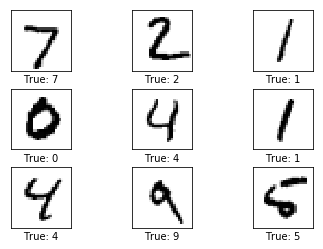

In [7]:
# Get the first images from the test-set.
images = x_test[0:9]

# Get the true classes for those images.
cls_true = y_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Input Functions for the Estimator

Rather than providing raw data directly to the Estimator, we must provide functions that return the data. This allows for more flexibility in data-sources and how the data is randomly shuffled and iterated.

Note that we will create an Estimator using the `DNNClassifier` which assumes the class-numbers are integers so we use `data.y_train_cls` instead of `data.y_train` which are one-hot encoded arrays.

The function also has parameters for `batch_size`, `queue_capacity` and `num_threads` for finer control of the data reading. In our case we take the data directly from a numpy array in memory, so it is not needed.

In [8]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    num_epochs=None,
    shuffle=True)

This actually returns a function:

In [9]:
train_input_fn

<function tensorflow.python.estimator.inputs.numpy_io.numpy_input_fn.<locals>.input_fn()>

Calling this function returns a tuple with TensorFlow ops for returning the input and output data:

In [10]:
train_input_fn()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


({'x': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(128, 28, 28) dtype=float32>},
 <tf.Tensor 'random_shuffle_queue_DequeueMany:2' shape=(128,) dtype=int32>)

Similarly we need to create a function for reading the data for the test-set. Note that we only want to process these images once so `num_epochs=1` and we do not want the images shuffled so `shuffle=False`.

In [11]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

An input-function is also needed for predicting the class of new data. As an example we just use a few images from the test-set.

In [12]:
some_images = x_test[0:9]

In [13]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": some_images},
    num_epochs=1,
    shuffle=False)

The class-numbers are actually not used in the input-function as it is not needed for prediction. However, the true class-number is needed when we plot the images further below.

In [14]:
some_images_cls = y_test[0:9]

## Pre-Made Estimator

When using a pre-made Estimator, we need to specify the input features for the data. In this case we want to input images from our data-set which are numeric arrays of the given shape.

In [15]:
feature_x = tf.feature_column.numeric_column("x", shape=img_shape)

You can have several input features which would then be combined in a list:

In [16]:
feature_columns = [feature_x]

In this example we want to use a 3-layer DNN with 512, 256 and 128 units respectively.

In [17]:
num_hidden_units = [512, 256, 128]

The `DNNClassifier` then constructs the neural network for us. We can also specify the activation function and various other parameters (see the docs). Here we just specify the number of classes and the directory where the checkpoints will be saved.

In [18]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_tutorial17-1/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7b7ca71732b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

We can now train the model for a given number of iterations. This automatically loads and saves checkpoints so we can continue the training later.

Note that the text `INFO:tensorflow:` is printed on every line and makes it harder to quickly read the actual progress. It should have been printed on a single line instead.

In [19]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-1/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 4000 into ./checkpoints_tutorial17-1/model.ckpt.
INFO:tensorflow:loss = 9.395486, step = 4001
INFO:tensorflow:global_step/sec: 66.451
INFO:tensorflow:loss = 14.377965, step = 4101 (1.507 sec)
INFO:tensorflow:global_step/sec: 82.5227
INFO:tensorflow:loss = 12.7375, step = 4201 (1.212 sec)
INFO:tensorflow:global_step/sec: 83.2106
INFO:tensorflow:loss = 24.21097, step = 4301 (1.201 sec)
INFO:tensorflow:global_step/sec: 82.1021
INFO:tensorflow:loss = 2.4398685, step = 4401 (1.220 sec)
INFO:tensorflow:global_step/sec: 82.9622
INFO:tensorflow:loss = 7.4433

### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [20]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-29-02:25:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-1/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-29-02:25:50
INFO:tensorflow:Saving dict for global step 6000: accuracy = 0.9406, average_loss = 0.25792468, global_step = 6000, loss = 32.648693
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: ./checkpoints_tutorial17-1/model.ckpt-6000


In [21]:
result

{'accuracy': 0.9406,
 'average_loss': 0.25792468,
 'loss': 32.648693,
 'global_step': 6000}

In [22]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 94.06%


### Predictions

The trained model can also be used to make predictions on new data.

Note that the TensorFlow graph is recreated and the checkpoint is reloaded every time we make predictions on new data. If the model is very large then this could add a significant overhead.

It is unclear why the Estimator is designed this way, possibly because it will always use the latest checkpoint and it can also be distributed easily for use on multiple computers.

In [23]:
predictions = model.predict(input_fn=predict_input_fn)

In [24]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-1/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [25]:
cls_pred = np.array(cls, dtype='int').squeeze()
cls_pred

array([7, 2, 1, 0, 4, 1, 4, 9, 4])

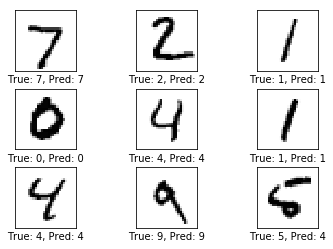

In [26]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

# New Estimator

If you cannot use one of the built-in Estimators, then you can create an arbitrary TensorFlow model yourself. To do this, you first need to create a function which defines the following:

1. The TensorFlow model, e.g. a Convolutional Neural Network.
2. The output of the model.
3. The loss-function used to improve the model during optimization.
4. The optimization method.
5. Performance metrics.

The Estimator can be run in three modes: Training, Evaluation, or Prediction. The code is mostly the same, but in Prediction-mode we do not need to setup the loss-function and optimizer.

This is another aspect of the Estimator API that is poorly designed and resembles how we did ANSI C programming using structs in the old days. It would probably have been more elegant to split this into several functions and sub-classed the Estimator-class.

In [32]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn,
    #           see e.g. train_input_fn for these two.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "x" in the input-function.
    x = features["x"]

    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])    

    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=16, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=36, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc2',
                          units=10)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

### Create an Instance of the Estimator

We can specify hyper-parameters e.g. for the learning-rate of the optimizer.

In [33]:
params = {"learning_rate": 1e-4}

We can then create an instance of the new Estimator.

Note that we don't provide feature-columns here as it is inferred automatically from the data-functions when `model_fn()` is called.

It is unclear from the TensorFlow documentation why it is necessary to specify the feature-columns when using `DNNClassifier` in the example above, when it is not needed here.

In [34]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./checkpoints_tutorial17-2/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7b7c35e13748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

Now that our new Estimator has been created, we can train it.

In [35]:
model.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-2/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2000 into ./checkpoints_tutorial17-2/model.ckpt.
INFO:tensorflow:loss = 0.023851601, step = 2001
INFO:tensorflow:global_step/sec: 10.5637
INFO:tensorflow:loss = 0.13545422, step = 2101 (9.470 sec)
INFO:tensorflow:global_step/sec: 7.32883
INFO:tensorflow:loss = 0.2512992, step = 2201 (13.644 sec)
INFO:tensorflow:global_step/sec: 5.53496
INFO:tensorflow:loss = 0.003182118, step = 2301 (18.100 sec)
INFO:tensorflow:global_step/sec: 5.29812
INFO:tensorflow:loss = 0.0671534, step = 2401 (18.847 sec)
INFO:tensorflow:global_step/sec: 5.36407
INFO:tensorflow:loss = 0.021585561, step = 2501 (18.649 sec)
INFO:tensorflow:global_step/sec: 6.125

### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [36]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-29-02:30:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-2/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-29-02:30:11
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.974, global_step = 3000, loss = 0.09830209
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: ./checkpoints_tutorial17-2/model.ckpt-3000


In [37]:
result

{'accuracy': 0.974, 'loss': 0.09830209, 'global_step': 3000}

In [38]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 97.40%


### Predictions

The model can also be used to make predictions on new data.

In [40]:
predictions = model.predict(input_fn=predict_input_fn)

In [41]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial17-2/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([7, 2, 1, 0, 4, 1, 4, 9, 5])

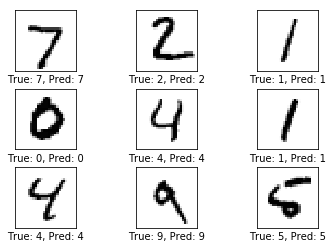

In [42]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

---
## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.